In [2]:
from crp.attribution import CondAttribution
from zennit.attribution import Gradient
from zennit.canonizers import CompositeCanonizer
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.visualization import FeatureVisualization
from crp.image import plot_grid

from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
import zennit as zen
import torch.nn as nn
import torch
import zennit.torchvision as ztv
from crp.image import imgify


from relevance import plot_relevance
from model import get_vggs_and_path, get_resnets_and_path, get_remote_models_and_path
from plot_and_print import plot_tile
from data_loader import TileLoader
import os
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from data_loader import get_data_loaders, get_dataset, STDataset

In [3]:
def plot_heatmaps(imgs, image_path, width=4, subplot_size=30):
    # +1 because we have the original tile plotted as extra image and +0.999 because we want to round up in case it is not perfectly dividable
    height = int((len(imgs) + 1) / width + 0.999)
    plt.figure(figsize=(width * subplot_size, height * subplot_size))

    f, ax = plt.subplots(height, width)
    f.set_figheight(subplot_size)
    f.set_figwidth(subplot_size)
    for i in range(len(imgs)):
        ax[int(i / width), i % width].imshow(imgs[i][0])
        ax[int(i / width), i % width].set_title(imgs[i][1])
        ax[int(i / width), i % width].axis('off')

    img = Image.open(image_path)
    ax[-1, -1].imshow(img)
    ax[-1, -1].set_title('original')
    ax[-1, -1].axis('off')
    plt.show()

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


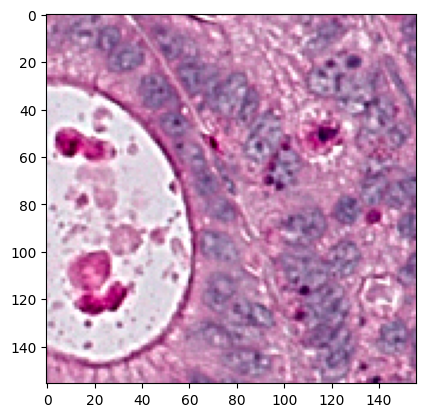

In [4]:
models = get_remote_models_and_path()
loader = TileLoader()

tile_path = "../Test_Data/p026/Tiles_156/p026_11_60.tiff"

data = loader.open(tile_path).unsqueeze(0)
target = 2.580166
data.requires_grad_(True)
plot_tile(tile_path)

In [5]:
model = models[3][0]
print(models[3][1])
composite_res = zen.composites.EpsilonPlusFlat(canonizers=[ztv.ResNetCanonizer()])
# TODO: check if cannonizer uses basic block / bottle neck



# is either torchvision.models.resnet.BasicBlock or 
# torchvision.models.resnet.Bottleneck
bottleneck_type = model.pretrained.layer1[0].__class__
print(bottleneck_type)

../remote_models/new/models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt
<class 'torchvision.models.resnet.BasicBlock'>


In [6]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_heatmaps(imgs, image_path, width=4, subplot_size=4):
    # Calculate the height of the plot grid
    height = int((len(imgs) + 1) / width + 0.999)
    
    # Set the figure size (width * subplot_size, height * subplot_size)
    f, ax = plt.subplots(height, width, figsize=(width * subplot_size, height * subplot_size), constrained_layout=True)
    
    # Loop to display images
    for i in range(len(imgs)):
        ax[int(i / width), i % width].imshow(imgs[i][0])
        ax[int(i / width), i % width].set_title(imgs[i][1])
        ax[int(i / width), i % width].axis('off')  # Optionally remove axes for a cleaner look

    # Plot the last image
    img = Image.open(image_path)
    ax[-1, -1].imshow(img)
    ax[-1, -1].set_title('original')
    ax[-1, -1].axis('off')  # Optionally remove axes for a cleaner look

    plt.show()

# Example call to the function (assuming `imgs` and `image_path` are defined)
# plot_heatmaps(imgs, image_path)


['pretrained.layer1.0', 'pretrained.layer1.1', 'pretrained.layer2.0', 'pretrained.layer2.1', 'pretrained.layer3.0', 'pretrained.layer3.1', 'pretrained.layer4.0', 'pretrained.layer4.1']


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

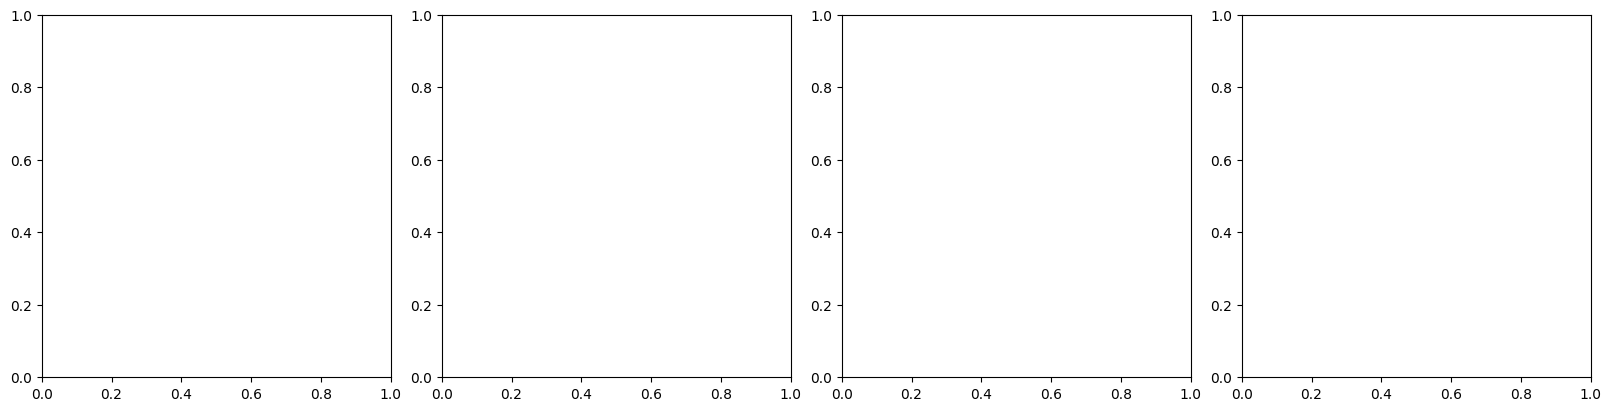

In [7]:
attribution = CondAttribution(model)

# here, each channel is defined as a concept
# or define your own notion!
cc = ChannelConcept()

# get layer names of Conv2D and MLP layers
layer_names = get_layer_names(model, [bottleneck_type])
print(layer_names)
# get a conditional attribution for channel 50 in layer features.27 wrt. output 1
#conditions = [{"y":[0], "gene1.0": [35]}]

heatmaps = []
"""
for layer in layer_names:
    conditions = [{"y":[0], layer:[0]}]
    
    attr = attribution(data, conditions, composite_res, record_layer=layer_names)
    heatmaps.append((attr.heatmap.squeeze(), layer))
"""

for i in range (0):
    conditions = [{"y":[0], "pretrained.layer4.1":[i]}]
    
    attr = attribution(data, conditions, composite_res, record_layer=layer_names)
    heatmaps.append((attr.heatmap.squeeze(), "pretrained.layer4.1 " + str(i)))

with Gradient(model, composite_res) as attributor:
    out, grad = attributor(data)
rel = plot_relevance(grad, filename=None, only_return=True)
heatmaps.append((rel, "unfiltered LRP"))

plot_heatmaps(heatmaps, tile_path, 4)


# heatmap and prediction
#attr.heatmap, attr.prediction
# activations and relevances for each layer name
#attr.activations, attr.relevances

# relative importance of each concept for final prediction
rel_c = cc.attribute(attr.relevances['pretrained.layer1.0'])
concept_ids = torch.argsort(rel_c, descending=True)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [8]:
model

Res18_1000(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [9]:
from crp.helper import get_layer_names

layer_names = get_layer_names(model, [bottleneck_type])

conditions = [{'y': [0]}]
attr = attribution(data, conditions, composite_res, record_layer=layer_names)

print(attr.activations['pretrained.layer4.1'].shape, attr.relevances['pretrained.layer4.1'].shape)
# attr[1]["features.40"].shape, attr[2]["features.40"].shape # is equivalent
# layer features.40 has 512 channel concepts
rel_c = cc.attribute(attr.relevances['pretrained.layer4.1'], abs_norm=True)
print(rel_c.shape)
# the six most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
concept_ids, rel_values*100



torch.Size([1, 512, 7, 7]) torch.Size([1, 512, 7, 7])
torch.Size([1, 512])


(tensor([321, 280, 403, 364, 206, 359]),
 tensor([2.3959, 1.3535, 1.1841, 1.0870, 0.9156, 0.8978]))

tensor([321, 280, 403, 364, 206, 359])


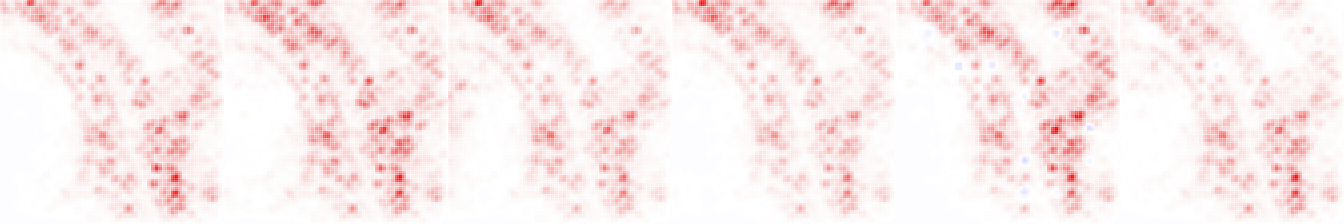

In [10]:

print(concept_ids)
conditions = [{'pretrained.layer4.1': [id], 'y': [0]} for id in concept_ids]

heatmap, _, _, _ = attribution(data, conditions, composite_res)

imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)))



In [11]:
conditions = [{'pretrained.layer4.1': [id], 'y': [0]} for id in torch.arange(0, 512)]

for attr in attribution.generate(data, conditions, composite_res, record_layer=layer_names, batch_size=10):
    pass


 46%|████▌     | 24/52 [00:10<00:13,  2.14it/s]

KeyboardInterrupt: 

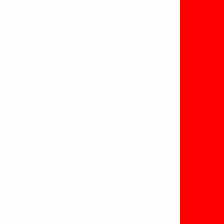

In [12]:


mask = torch.zeros(224, 224).to(attribution.device)
mask[:, 180:] = 1

imgify(mask, symmetric=True)



In [13]:
from crp.helper import abs_norm

rel_c = []
for attr in attribution.generate(data, conditions, composite_res, record_layer=layer_names, batch_size=10):
    
    masked = attr.heatmap * mask[None, :, :]
    rel_c.append(torch.sum(masked, dim=(1, 2)))

rel_c = torch.cat(rel_c)

indices = torch.topk(rel_c, 5).indices
# we norm here, so that we clearly see the contribution inside the masked region as percentage
indices, abs_norm(rel_c)[indices]*100


100%|██████████| 52/52 [00:24<00:00,  2.13it/s]


(tensor([321, 280,  63, 206, 364]),
 tensor([2.7015, 1.4095, 1.4003, 1.1625, 1.0780]))

In [14]:
conditions = [{"y": [0], "pretrained.layer4.1": [469]}]

attr = attribution(data, conditions, composite_res, record_layer=["pretrained.layer2.1"])

rel_c = cc.attribute(attr.relevances["pretrained.layer2.1"], abs_norm=True)

# five concepts in features.37 that contributed the most to the activation of channel 469 in features.40
# while being relevant for the classification of the lizard class
torch.argsort(rel_c, descending=True)[0, :5]


tensor([87, 54, 21, 31, 95])

In [15]:
from crp.graph import trace_model_graph

graph = trace_model_graph(model, data, layer_names)
print(graph)

__module.pretrained/__module.pretrained.conv1 -> __module.pretrained/__module.pretrained.bn1, 
__module.pretrained/__module.pretrained.bn1 -> __module.pretrained/__module.pretrained.relu, 
__module.pretrained/__module.pretrained.relu -> __module.pretrained/__module.pretrained.maxpool, 
__module.pretrained/__module.pretrained.maxpool -> __module.pretrained/__module.pretrained.layer1/__module.pretrained.layer1.0/__module.pretrained.layer1.0.conv1, __module.pretrained/__module.pretrained.layer1/__module.pretrained.layer1.0, 
__module.pretrained/__module.pretrained.layer1/__module.pretrained.layer1.0/__module.pretrained.layer1.0.conv1 -> __module.pretrained/__module.pretrained.layer1/__module.pretrained.layer1.0/__module.pretrained.layer1.0.bn1, 
__module.pretrained/__module.pretrained.layer1/__module.pretrained.layer1.0/__module.pretrained.layer1.0.bn1 -> __module.pretrained/__module.pretrained.layer1/__module.pretrained.layer1.0/__module.pretrained.layer1.0.relu, 
__module.pretrained/__m

In [16]:
graph.find_input_layers("pretrained.layer4.1")

['pretrained.layer4.0', 'pretrained.layer4.0']

In [17]:
from crp.attribution import AttributionGraph

layer_names = get_layer_names(model, [bottleneck_type])
    
layer_map = {name: cc for name in layer_names}
print(layer_map)
attgraph = AttributionGraph(attribution, graph, layer_map)

# decompose concept 71 in features.40 w.r.t. target 46 (lizard class)
# width=[5, 2] returns first the 5 most relevant concepts in the previous lower-level layer
# and in the second iteration returns for each of the 5 most relevant concepts again the two
# most relevant concepts in the previous lower-level layer
nodes, connections = attgraph(data, composite_res, 71, "pretrained.layer4.1", 0, width=[5, 2], abs_norm=True)
print("Nodes:\n", nodes, "\nConnections:\n", connections)


{'pretrained.layer1.0': <crp.concepts.ChannelConcept object at 0x177f4f460>, 'pretrained.layer1.1': <crp.concepts.ChannelConcept object at 0x177f4f460>, 'pretrained.layer2.0': <crp.concepts.ChannelConcept object at 0x177f4f460>, 'pretrained.layer2.1': <crp.concepts.ChannelConcept object at 0x177f4f460>, 'pretrained.layer3.0': <crp.concepts.ChannelConcept object at 0x177f4f460>, 'pretrained.layer3.1': <crp.concepts.ChannelConcept object at 0x177f4f460>, 'pretrained.layer4.0': <crp.concepts.ChannelConcept object at 0x177f4f460>, 'pretrained.layer4.1': <crp.concepts.ChannelConcept object at 0x177f4f460>}



100%|██████████| 1/1 [00:00<00:00,  9.84it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

Nodes:
 [('pretrained.layer4.1', 71), ('pretrained.layer4.0', 71), ('pretrained.layer4.0', 100), ('pretrained.layer4.0', 322), ('pretrained.layer4.0', 191), ('pretrained.layer4.0', 383), ('pretrained.layer4.0', 71), ('pretrained.layer4.0', 100), ('pretrained.layer4.0', 322), ('pretrained.layer4.0', 191), ('pretrained.layer4.0', 383), ('pretrained.layer3.1', 44), ('pretrained.layer3.1', 68), ('pretrained.layer3.1', 44), ('pretrained.layer3.1', 68), ('pretrained.layer3.1', 121), ('pretrained.layer3.1', 63), ('pretrained.layer3.1', 121), ('pretrained.layer3.1', 63), ('pretrained.layer3.1', 138), ('pretrained.layer3.1', 121), ('pretrained.layer3.1', 138), ('pretrained.layer3.1', 121), ('pretrained.layer3.1', 14), ('pretrained.layer3.1', 174), ('pretrained.layer3.1', 14), ('pretrained.layer3.1', 174), ('pretrained.layer3.1', 63), ('pretrained.layer3.1', 106), ('pretrained.layer3.1', 63), ('pretrained.layer3.1', 106), ('pretrained.layer3.1', 44), ('pretrained.layer3.1', 68), ('pretrained.lay

In [18]:
nodes

[('pretrained.layer4.1', 71),
 ('pretrained.layer4.0', 71),
 ('pretrained.layer4.0', 100),
 ('pretrained.layer4.0', 322),
 ('pretrained.layer4.0', 191),
 ('pretrained.layer4.0', 383),
 ('pretrained.layer4.0', 71),
 ('pretrained.layer4.0', 100),
 ('pretrained.layer4.0', 322),
 ('pretrained.layer4.0', 191),
 ('pretrained.layer4.0', 383),
 ('pretrained.layer3.1', 44),
 ('pretrained.layer3.1', 68),
 ('pretrained.layer3.1', 44),
 ('pretrained.layer3.1', 68),
 ('pretrained.layer3.1', 121),
 ('pretrained.layer3.1', 63),
 ('pretrained.layer3.1', 121),
 ('pretrained.layer3.1', 63),
 ('pretrained.layer3.1', 138),
 ('pretrained.layer3.1', 121),
 ('pretrained.layer3.1', 138),
 ('pretrained.layer3.1', 121),
 ('pretrained.layer3.1', 14),
 ('pretrained.layer3.1', 174),
 ('pretrained.layer3.1', 14),
 ('pretrained.layer3.1', 174),
 ('pretrained.layer3.1', 63),
 ('pretrained.layer3.1', 106),
 ('pretrained.layer3.1', 63),
 ('pretrained.layer3.1', 106),
 ('pretrained.layer3.1', 44),
 ('pretrained.layer3.1

In [19]:
connections[("pretrained.layer4.1", 71)]

[('pretrained.layer4.0', 71, 0.14399713277816772),
 ('pretrained.layer4.0', 100, 0.014780795201659203),
 ('pretrained.layer4.0', 322, 0.01444489136338234),
 ('pretrained.layer4.0', 191, 0.01297715213149786),
 ('pretrained.layer4.0', 383, 0.012682530097663403),
 ('pretrained.layer4.0', 71, 0.14399713277816772),
 ('pretrained.layer4.0', 100, 0.014780795201659203),
 ('pretrained.layer4.0', 322, 0.01444489136338234),
 ('pretrained.layer4.0', 191, 0.01297715213149786),
 ('pretrained.layer4.0', 383, 0.012682530097663403)]

In [18]:
#device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
model.to(device)

Res18_1000(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
data_dir = "../Training_Data/"
train_loader, val_loader = get_data_loaders(data_dir, 64)
dataset = get_dataset(data_dir)
from torchvision import transforms

class STDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, device="mps", transforms=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            # mean and std of the whole dataset
            transforms.Normalize([0.7406, 0.5331, 0.7059], [0.1651, 0.2174, 0.1574])
            ])):
        self.dataframe = dataframe
        self.transforms = transforms
        self.device = device

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        gene_names = list(self.dataframe)[1:]
        gene_vals = []
        row = self.dataframe.iloc[index]
        a = Image.open(row["tile"]).convert("RGB")
        # print(x.size)
        for j in gene_names:
            gene_val = float(row[j])
            gene_vals.append(gene_val)
        e = row["tile"]
        # apply normalization transforms as for pretrained colon classifier
        a = self.transforms(a)
        a = a.to(self.device)
        return a, 0
datasetST = STDataset(dataset)

In [20]:
device = "cpu"
print(device)
print(model.to(device))

cpu
Res18_1000(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [21]:
import torchvision
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
import torchvision.transforms as T

cc = ChannelConcept()

layer_names = get_layer_names(model, [bottleneck_type])
layer_map = {layer : cc for layer in layer_names}
model.to(device)
print(next(model.parameters()).is_mps)
attribution = CondAttribution(model)

# separate normalization from resizing for plotting purposes later
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


# apply no normalization here!
#imagenet_data = torchvision.datasets.ImageNet(train_loader, transform=transform, split="val")  
fv_path = "output_crp"
fv = FeatureVisualization(attribution, datasetST, layer_map, preprocess_fn=preprocessing, path=fv_path)



# it will take approximately 20 min on a Titan RTX
#print(device)
saved_files = fv.run(composite_res, 0, len(datasetST), 124, 100)



False
Running Analysis...



100%|██████████| 208/208 [1:11:45<00:00, 20.70s/it]



100%|██████████| 24/24 [00:00<00:00, 611.69it/s]

100%|██████████| 24/24 [00:00<00:00, 626.93it/s]

100%|██████████| 24/24 [00:00<00:00, 565.98it/s]

100%|██████████| 24/24 [00:00<00:00, 662.65it/s]


In [22]:
len(datasetST)/64



402.875

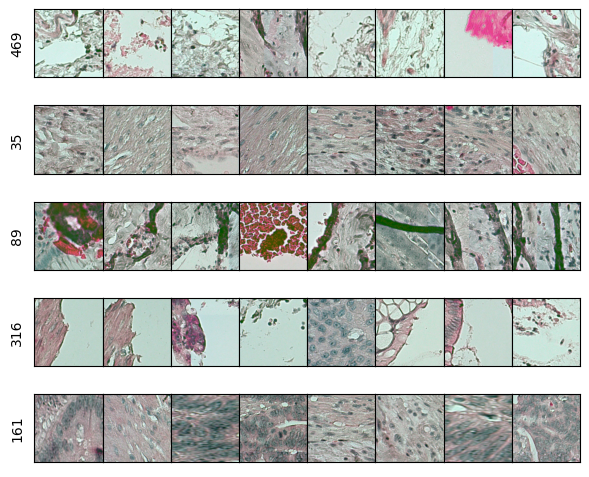

In [28]:
#%matplotlib inline
from crp.image import plot_grid

ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "pretrained.layer4.1", "relevance", (0, 8))

plot_grid(ref_c, figsize=(6, 5), padding=False)


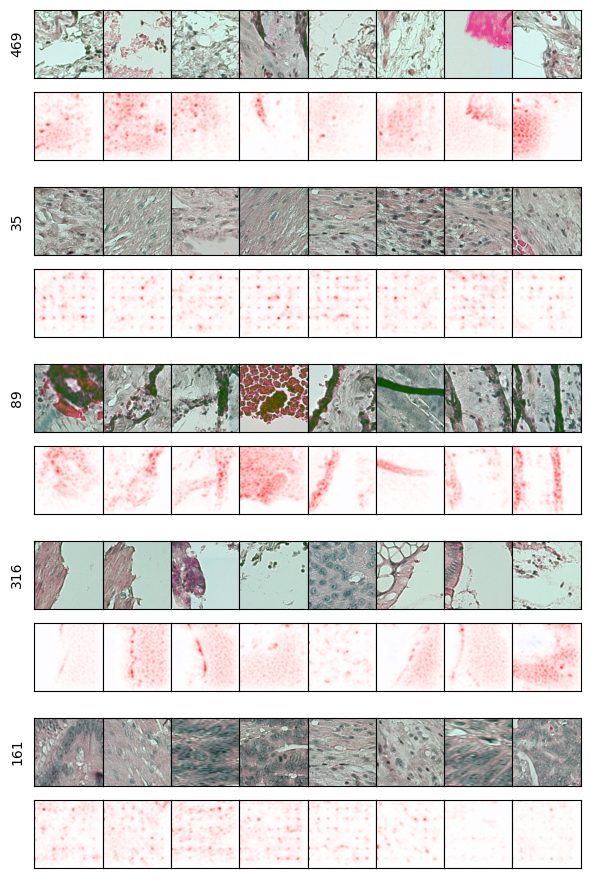

In [29]:
ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "pretrained.layer4.1", "relevance", (0, 8), composite=composite_res, plot_fn=None)

plot_grid(ref_c, figsize=(6, 9))

/Users/jona/.pyenv/versions/3.10.7/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


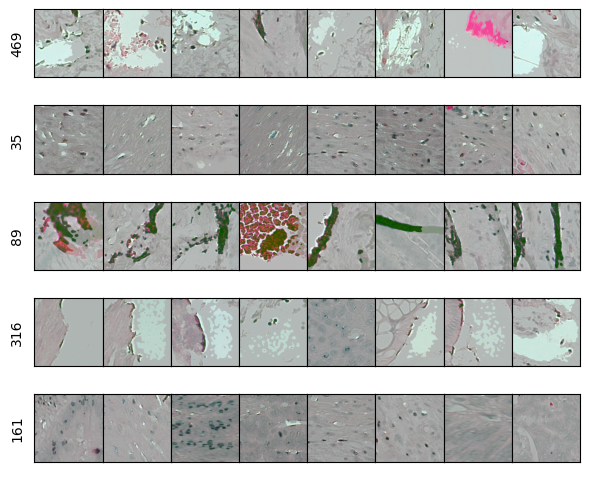

In [30]:
from crp.image import vis_opaque_img

ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "pretrained.layer4.1", "relevance", (0, 8), composite=composite_res, plot_fn=vis_opaque_img)

plot_grid(ref_c, cmap="bwr", symmetric=True, figsize=(6, 5))


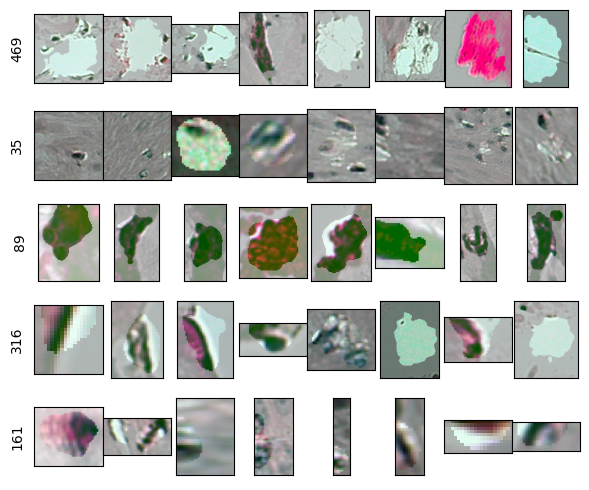

In [31]:
ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "pretrained.layer4.1", "relevance", (0, 8), rf=True, composite=composite_res, plot_fn=vis_opaque_img)

plot_grid(ref_c, figsize=(6, 5), padding=False)


In [32]:
targets, rel = fv.compute_stats(469, "pretrained.layer4.1", "relevance", top_N=5, norm=True)
targets, rel 


(0, tensor([1.]))

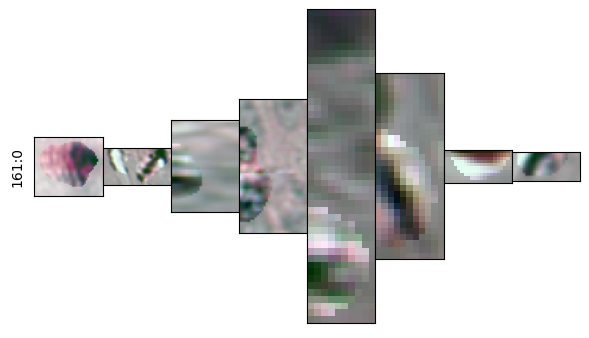

In [33]:
ref_t = fv.get_stats_reference(161, "pretrained.layer4.1", targets, "relevance", (0, 8), rf=True, composite=composite_res, plot_fn=vis_opaque_img)

plot_grid(ref_t, figsize=(6, 5), padding=False)

In [34]:
from crp.cache import ImageCache

cache = ImageCache(path="cache")

fv = FeatureVisualization(attribution, datasetST, layer_map, preprocess_fn=preprocessing, path=fv_path, cache=cache)


In [35]:
from crp.helper import get_output_shapes
import numpy as np

layer_names = get_layer_names(model, [bottleneck_type])
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_opaque_img], mode="relevance", r_range=(0, 16), composite=composite_res, rf=True, batch_size=32, stats=False)


Layer: pretrained.layer1.0



100%|██████████| 64/64 [01:34<00:00,  1.48s/it]


Layer: pretrained.layer1.1



100%|██████████| 64/64 [01:58<00:00,  1.85s/it]


Layer: pretrained.layer2.0



100%|██████████| 128/128 [04:24<00:00,  2.07s/it]


Layer: pretrained.layer2.1



100%|██████████| 128/128 [04:55<00:00,  2.31s/it]


Layer: pretrained.layer3.0



100%|██████████| 256/256 [10:14<00:00,  2.40s/it]


Layer: pretrained.layer3.1



100%|██████████| 256/256 [11:31<00:00,  2.70s/it]


Layer: pretrained.layer4.0



100%|██████████| 512/512 [24:35<00:00,  2.88s/it]


Layer: pretrained.layer4.1



100%|██████████| 512/512 [26:01<00:00,  3.05s/it]
